In [1]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
import scipy
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
import tqdm

np.random.seed(42)

In [2]:
def generate_knn(n: int, d: int):
    points = ss.norm.rvs(size=(n, d))
    A = kneighbors_graph(points, 1, mode='connectivity', include_self=False)
    return A, points

def generate_mask(n: int, n1: int):
    first_sample = np.random.choice(n, size=n1, replace=False)
    # first_sample = np.arange(n1)
    mask = np.zeros(n, dtype=bool)
    mask[first_sample] = 1
    return mask

In [3]:
def compute_l(mask, A):
    return np.sum(A[mask.reshape(-1, 1) * mask.reshape(1, -1)])

def compute_symm_l(mask, A):
    return np.sum(A[mask.reshape(-1, 1) * mask.reshape(1, -1)]) + np.sum(A[(~mask).reshape(-1, 1) * (~mask).reshape(1, -1)])

In [11]:
n_iter = 10000
n = 1000
d = 200
n1 = n // 2
ls = []
A, points = generate_knn(n, d)
A = np.array(A.todense())
for _ in tqdm.tqdm(range(n_iter)):
    mask = generate_mask(n, n1)
    ls.append(compute_l(mask, A))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:26<00:00, 372.10it/s]


In [4]:
def get_params(n: int, n1: int, A: np.ndarray):
    mu = n1*(n1 - 1) / (n-1)
    d = np.array(A.sum(axis=0)).ravel()
    cn = np.mean((d - 1)**2)
    vn = np.sum(A * A.T) / n / 2
    var = 4*n1*(n1-1)*(n-n1)*n / (n*(n-1)*(n-2)*(n-3)) * ((n1 - 2) * cn + (n - n1 - 1) * (1 + vn - 2/(n-1)))
    # var = 4*n1*(n1-1)*(n1-2)*(n-n1) / ((n-1)*(n-2)*(n-3)) * cn + 2*n1*(n1-1)*(n-n1)*(n-n1-1) / (n*(n-1)*(n-2)*(n-3)) / (n*(n-1)) * (2*n*(n-1)*n*(1 + vn) - 4*n**2) 
    var /= 4
    return mu, var

def get_symm_params(n: int, n1: int, A: np.ndarray):
    n2 = n - n1
    mu = (n1*(n1 - 1) + n2*(n2 - 1)) / (n-1)
    d = np.array(A.sum(axis=0)).ravel()
    cn = np.mean((d - 1)**2)
    vn = np.sum(A * A.T) / n / 2
    q = 4 * (n1 - 1) * (n2 - 1) / ((n - 2) * (n - 3))
    var = n1 * n2 / (n - 1) * (q * (1 + vn - 2 / (n - 1)) + (1-q)*cn)
    # var = 4*n1*(n1-1)*(n-n1)*n / (n*(n-1)*(n-2)*(n-3)) * ((n1 - 2) * cn + (n - n1 - 1) * (1 + vn - 2/(n-1)))
    # var = 4*n1*(n1-1)*(n1-2)*(n-n1) / ((n-1)*(n-2)*(n-3)) * cn + 2*n1*(n1-1)*(n-n1)*(n-n1-1) / (n*(n-1)*(n-2)*(n-3)) / (n*(n-1)) * (2*n*(n-1)*n*(1 + vn) - 4*n**2)
    # var /= 4

    return mu, var

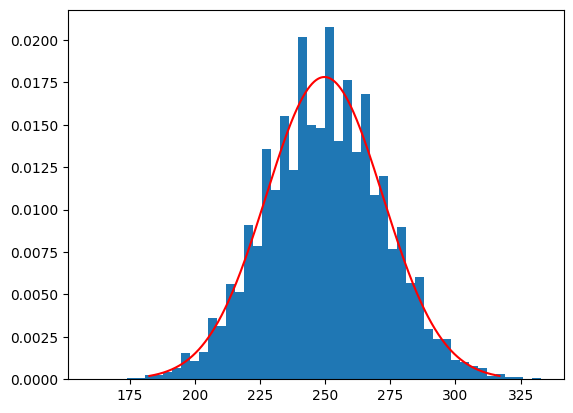

Data mean: 249.9136, predicted mean: 249.74974974974975
Data var: 512.0073357735774, predicted var: 501.1945246401117


In [13]:
plt.hist(ls, bins=50, density=True)
mu, var = get_params(n, n1, A)
sigma = np.sqrt(var)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = ss.norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, y, color='red')
plt.show()

print(f"Data mean: {np.mean(ls)}, predicted mean: {mu}")
print(f"Data var: {np.var(ls, ddof=1)}, predicted var: {var}")

100%|██████████| 10000/10000 [00:54<00:00, 184.42it/s]


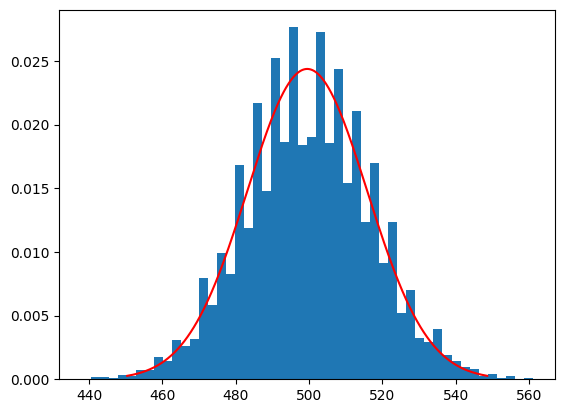

Data mean: 499.7402, predicted mean: 499.4994994994995
Data var: 289.00660462046204, predicted var: 267.95752673485987


In [14]:
n_iter = 10000
n = 1000
d = 200
n1 = n // 2
ls = []
A, points = generate_knn(n, d)
A = np.array(A.todense())
for _ in tqdm.tqdm(range(n_iter)):
    mask = generate_mask(n, n1)
    ls.append(compute_symm_l(mask, A))

plt.hist(ls, bins=50, density=True)
mu, var = get_symm_params(n, n1, A)
sigma = np.sqrt(var)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y = ss.norm.pdf(x, loc=mu, scale=sigma)
plt.plot(x, y, color='red')
plt.show()

print(f"Data mean: {np.mean(ls)}, predicted mean: {mu}")
print(f"Data var: {np.var(ls, ddof=1)}, predicted var: {var}")

In [5]:
def reject_asymm_hypo(points1, points2, a=0.05):
    n1 = len(points1)
    n = n1 + len(points2)
    points = np.vstack([points1, points2])
    A = kneighbors_graph(points, 1, mode='connectivity', include_self=False)
    A = np.array(A.todense())
    mask = np.zeros(n, dtype=bool)
    mask[:n1] = True
    l = compute_l(mask, A)
    mu, var = get_params(n, n1, A)
    c = mu + np.sqrt(var) * ss.norm.ppf(1 - a)
    return l >= c

def reject_asymm_rev_hypo(points1, points2, a=0.05):
    return reject_asymm_hypo(points2, points1, a)

def reject_symm_hypo(points1, points2, a=0.05):
    n1 = len(points1)
    n = n1 + len(points2)
    points = np.vstack([points1, points2])
    A = kneighbors_graph(points, 1, mode='connectivity', include_self=False)
    A = np.array(A.todense())
    mask = np.zeros(n, dtype=bool)
    mask[:n1] = True
    l = compute_symm_l(mask, A)
    mu, var = get_symm_params(n, n1, A)
    c = mu + np.sqrt(var) * ss.norm.ppf(1 - a)
    return l >= c

In [6]:
def test_significance_level(reject_fn, n_iter=1000, n=500, d=200):
    n1 = n // 2
    n2 = n - n1
    # H0 is true
    rej_cnt = 0
    for _ in tqdm.tqdm(range(n_iter)):
        points1 = ss.norm.rvs(size=(n1, d))
        points2 = ss.norm.rvs(size=(n2, d))
        rej_cnt += reject_fn(points1, points2)
    return rej_cnt / n_iter

In [17]:
print(f"Real significance level: {test_significance_level(reject_asymm_hypo)}")
print(f"Real significance level (symm): {test_significance_level(reject_symm_hypo)}")

100%|██████████| 1000/1000 [00:16<00:00, 59.12it/s]


Real significance level: 0.05


100%|██████████| 1000/1000 [00:15<00:00, 66.17it/s]

Real significance level (symm): 0.053


In [18]:
n_iter = 100
n = 200
n1 = n // 2
n2 = n - n1
# H0 is false
locs = np.logspace(np.log10(0.05), np.log10(50), 20)
x = np.logspace(0.5, 2.5, 25)
y = []
y_symm = []
for d in tqdm.tqdm(x):
    d = int(d)
    power = 0.0
    power_symm = 0.0
    for loc in locs:
        rej_cnt = 0
        rej_symm_cnt = 0
        for _ in range(n_iter):
            points1 = ss.norm.rvs(size=(n1, d))
            points2 = ss.norm.rvs(loc=loc, size=(n2, d))
            rej_cnt += reject_asymm_hypo(points1, points2)
            rej_symm_cnt += reject_symm_hypo(points1, points2)
        power += rej_cnt / n_iter
        power_symm += rej_symm_cnt / n_iter
    power /= len(locs)
    power_symm /= len(locs)
    y.append(power)
    y_symm.append(power_symm)

100%|██████████| 25/25 [04:44<00:00, 11.38s/it]


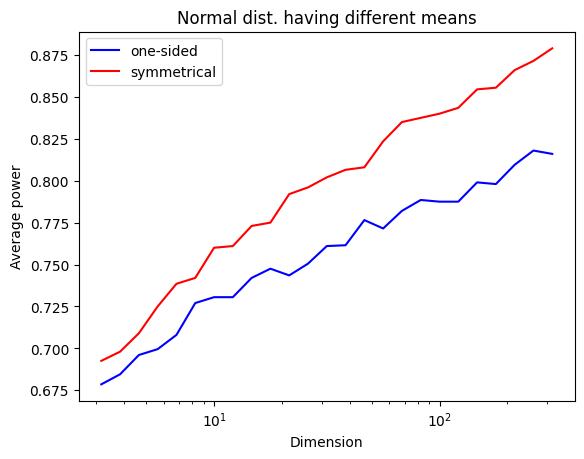

In [19]:
plt.plot(x, y, c='blue', label='one-sided')
plt.plot(x, y_symm, c='red', label='symmetrical')
plt.title("Normal dist. having different means")
plt.xlabel("Dimension")
plt.ylabel("Average power")
plt.xscale('log')
plt.legend()
plt.show()

In [7]:
def power_mean_experiment(tests: list, n_iter=100, n1=250, n2=250):
    means = np.logspace(np.log10(0.05), np.log10(50), 20)
    x = np.logspace(0.5, 2.0, 20)
    plot_points = [[] for test in tests]
    for d in tqdm.tqdm(x):
        d = int(d)
        powers = np.zeros(len(tests))
        for mean in means:
            rej_cnts = np.zeros(len(tests))
            for _ in range(n_iter):
                points1 = ss.norm.rvs(size=(n1, d))
                points2 = ss.norm.rvs(loc=mean, size=(n2, d))
                for i, test in enumerate(tests):
                    rej_cnts[i] += test(points1, points2)
            powers += rej_cnts / n_iter
        powers /= len(means)
        for i in range(len(tests)):
            plot_points[i].append(powers[i])
    return x, plot_points

def power_var_experiment(tests: list, n_iter=100, n1=250, n2=250):
    sigmas = np.logspace(0.01, 1.0, 20, base=10)
    x = np.logspace(0.5, 2.0, 20)
    plot_points = [[] for test in tests]
    for d in tqdm.tqdm(x):
        d = int(d)
        powers = np.zeros(len(tests))
        for sigma in sigmas:
            rej_cnts = np.zeros(len(tests))
            for _ in range(n_iter):
                points1 = ss.norm.rvs(size=(n1, d))
                points2 = ss.norm.rvs(scale=sigma, size=(n2, d))
                for i, test in enumerate(tests):
                    rej_cnts[i] += test(points1, points2)
            powers += rej_cnts / n_iter
        powers /= len(sigmas)
        for i in range(len(tests)):
            plot_points[i].append(powers[i])
    return x, plot_points

In [8]:
x, y_points = power_mean_experiment([reject_asymm_hypo, reject_asymm_rev_hypo, reject_symm_hypo])

100%|██████████| 20/20 [15:44<00:00, 47.21s/it]


In [ ]:
plt.plot(x, y, c='blue', label='one-sided')
plt.plot(x, y_symm, c='red', label='symmetrical')
plt.title("Normal dist. having different means")
plt.xlabel("Dimension")
plt.ylabel("Average power")
plt.xscale('log')
plt.legend()
plt.show()

In [21]:
x, y_points = power_var_experiment([reject_asymm_hypo, reject_asymm_rev_hypo, reject_symm_hypo])

100%|██████████| 20/20 [04:37<00:00, 13.86s/it]


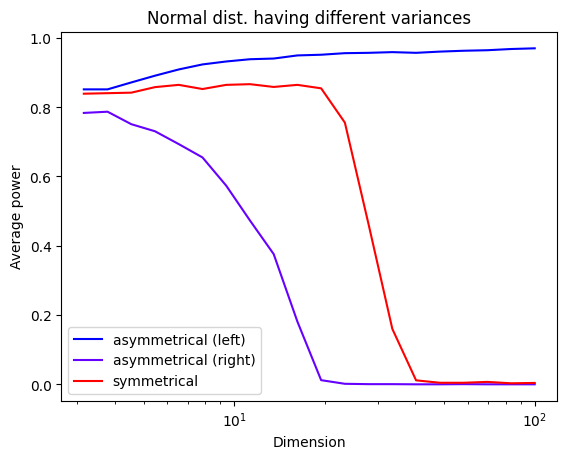

In [22]:
plt.plot(x, y_points[0], c='blue', label='asymmetrical (left)')
plt.plot(x, y_points[1], c=(0.4, 0.0, 1.0), label='asymmetrical (right)')
plt.plot(x, y_points[2], c='red', label='symmetrical')
plt.title("Normal dist. having different variances")
plt.xlabel("Dimension")
plt.ylabel("Average power")
plt.xscale('log')
plt.legend()
plt.show()

In [23]:
def mmd_2(x: np.ndarray, y: np.ndarray, kernel):
    assert x.shape == y.shape, "Formula only applicable with m = n"
    # shape = [m, d]
    m = len(x)
    d = x.shape[1]
    # z = np.hstack([x, y])
    # z_i = z.reshape(m, 1, 2*d)
    # z_j = z.reshape(1, m, 2*d)
    # return np.sum(kernel(z_i[..., :d], z_j[..., :d]) + kernel(z_i[..., d:], z_j[..., d:]) - kernel(z_i[..., :d], z_j[..., d:]) - kernel(z_i[..., d:], z_j[..., :d])) / (m*(m-1))

def mmd_lin(X: np.ndarray, Y: np.ndarray):
    delta = X.mean(axis=0) - Y.mean(axis=0)
    return delta.dot(delta.T)

def mmd_gaussian(X: np.ndarray, Y: np.ndarray, gamma = 1.0):
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

def gaussian_kernel(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    return np.exp(-np.sum((x - y) ** 2, axis=-1)/2)

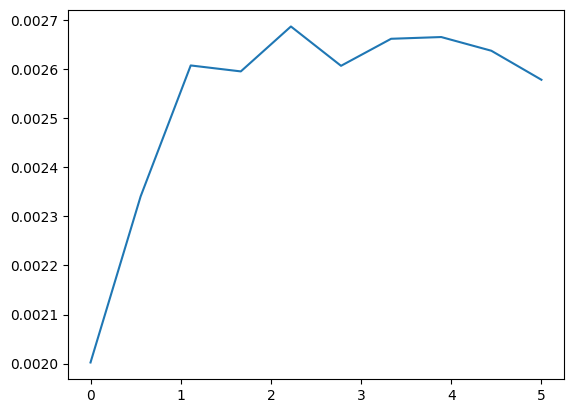

In [24]:
n1, n2 = 1000, 1000
d = 10
mmds = []
mus = np.linspace(0.0, 5.0, 10)
for dmu in mus:
    points1 = ss.norm.rvs(size=(n1, d))
    points2 = ss.norm.rvs(loc=dmu, size=(n2, d))
    mmds.append(mmd_gaussian(points1, points2))

plt.plot(mus, mmds)
plt.show()

In [40]:
def reject_mmd_hypo(points1, points2, alpha = 0.05, mmd_func=mmd_lin, bootstrap_iters=50):
    m = len(points1)
    mmd_obs = mmd_func(points1, points2)
    points = np.vstack([points1, points2])
    bootstrap_samples = np.zeros(bootstrap_iters)
    for i in range(bootstrap_iters):
        np.random.shuffle(points)
        bootstrap_samples[i] = mmd_func(points[:m], points[m:])
    
    threshold = np.quantile(bootstrap_samples, 1 - alpha)
    # print(mmd_obs)
    # plt.hist(bootstrap_samples, bins=15)
    # plt.show()
    return mmd_obs >= threshold

def reject_mmd_lin_hypo(points1, points2, alpha = 0.05):
    assert points1.shape == points2.shape
    m = len(points1)
    assert m % 2 == 0
    d = points1.shape[1]
    pairs1 = points1.reshape(-1, 2, d)
    pairs2 = points2.reshape(-1, 2, d)
    diffs = pairs1 - pairs2
    h_vals = np.sum(diffs[:, 0, :] * diffs[:, 1, :], axis=1)
    mmd2_lin = np.mean(h_vals)
    sigma2_hat = 2 * np.mean(h_vals**2)
    z_test = mmd2_lin / np.sqrt(sigma2_hat / m)
    z_crit = ss.norm.ppf(1 - alpha / 2)
    return np.abs(z_test) >= z_crit

In [26]:
test_significance_level(reject_mmd_hypo, n_iter=100, n=250)

100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


np.float64(0.04)

In [27]:
test_significance_level(reject_mmd_lin_hypo, n_iter=100, n=500)

100%|██████████| 100/100 [00:00<00:00, 371.61it/s]


np.float64(0.06)

In [ ]:
x, y_points = power_var_experiment([reject_asymm_hypo, reject_mmd_lin_hypo, reject_mmd_hypo], n_iter=100, n1=250, n2=250)

100%|██████████| 20/20 [05:29<00:00, 16.45s/it]


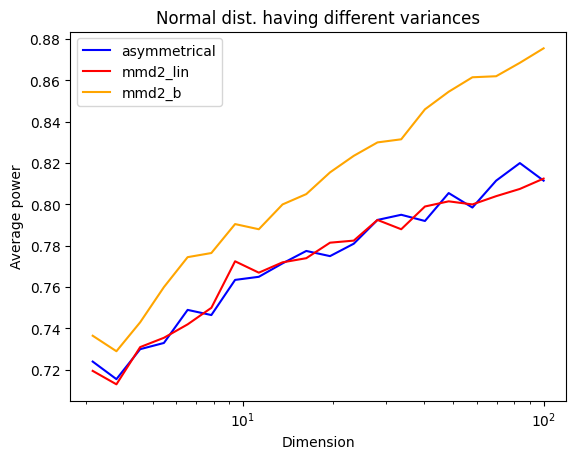

In [10]:
plt.plot(x, y_points[0], c='blue', label='asymmetrical')
plt.plot(x, y_points[1], c='red', label='mmd2_lin')
plt.plot(x, y_points[2], c='orange', label='mmd2_b')
plt.title("Normal dist. having different variances")
plt.xlabel("Dimension")
plt.ylabel("Average power")
plt.xscale('log')
plt.legend()
plt.show()

In [41]:
x, y_points = power_mean_experiment([reject_asymm_hypo, reject_mmd_lin_hypo, reject_mmd_hypo])

100%|██████████| 20/20 [24:39<00:00, 73.99s/it]


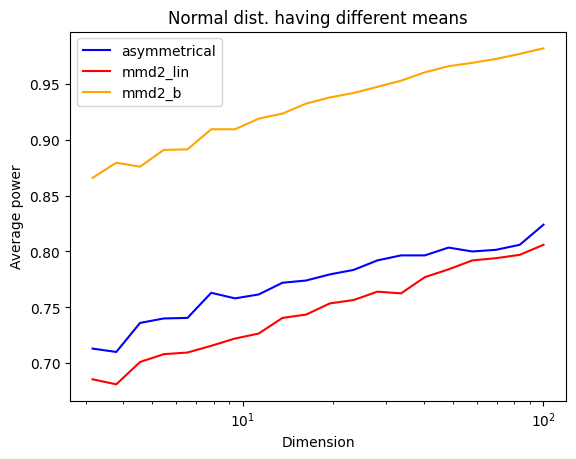

In [42]:
plt.plot(x, y_points[0], c='blue', label='asymmetrical')
plt.plot(x, y_points[1], c='red', label='mmd2_lin')
plt.plot(x, y_points[2], c='orange', label='mmd2_b')
plt.title("Normal dist. having different means")
plt.xlabel("Dimension")
plt.ylabel("Average power")
plt.xscale('log')
plt.legend()
plt.show()